### Ames Housing Project
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data 

### SECTION 1: SET UP

In [1]:
#Packages to use
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

#ignore annoying warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

#Limits floats to 3 decimals
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
#data
train = pd.read_csv('C:/Users/James.Kelly/DAT-06-24/class material/Unit 3/data/iowa_housing/train.csv')
test  = pd.read_csv('C:/Users/James.Kelly/DAT-06-24/class material/Unit 3/data/iowa_housing/test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Drop the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

### SECTION 2: OUTLIERS

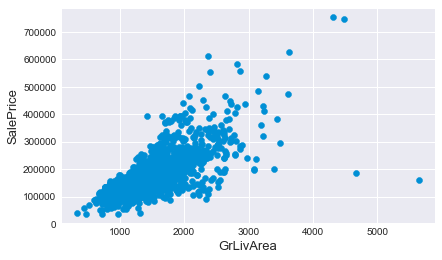

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [6]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

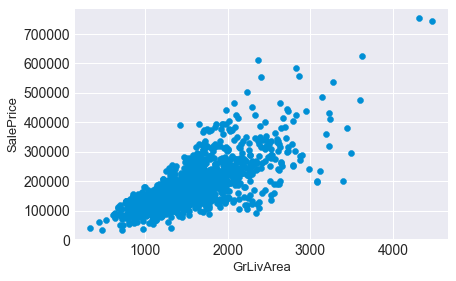

In [74]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### SET SALESPRICE

In [7]:
train["SalePrice"] = np.log1p(train["SalePrice"])

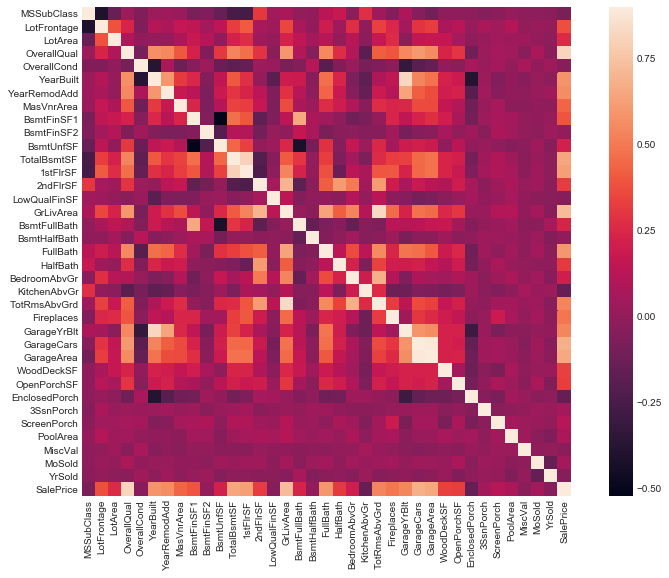

In [8]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## SET VARIABLES

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values


all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.000,0.000,...,WD,0,Pave,8,856.000,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.000,0.000,...,WD,0,Pave,6,1262.000,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.000,0.000,...,WD,0,Pave,6,920.000,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.000,0.000,...,WD,0,Pave,7,756.000,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.000,0.000,...,WD,0,Pave,9,1145.000,AllPub,192,2000,2000,2008


### Missing data

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


In [11]:
#for most of the categorical variables I set NA to 'NONE'
for col in ('PoolQC','MiscFeature', 'Alley','Fence','FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')


#for most of the float variables I set NA to '0'
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

#fill na's with MODE
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    
#This was the only variable I did something extra to - I set missing 'Lotfrontage' to the average of the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


#utilitie is all the same expect for 1 or 2 cells...so i just deleted it
all_data = all_data.drop(['Utilities'], axis=1)

#Kaggle data descriptions says NA = Typical
all_data["Functional"] = all_data["Functional"].fillna("Typical")


In [12]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [13]:
#Changed these to categorical variables
for col in ('OverallCond', 'YrSold', 'MoSold'):
    all_data[col] = all_data[col].astype(str)
    
    
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

In [14]:
#added a total square footage variable 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [15]:
#get dummies
all_data = pd.get_dummies(all_data, drop_first=True)

In [16]:
#sepperate train and test again
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

In [17]:
X_train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
count,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,...,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000
mean,1158.851,345.762,3.414,2.866,438.827,46.613,0.424,0.058,567.097,21.984,...,0.003,0.003,0.082,0.002,0.869,0.996,0.225,0.208,0.232,0.120
std,372.039,435.424,29.337,0.816,432.969,161.421,0.517,0.239,442.087,61.156,...,0.058,0.058,0.275,0.045,0.338,0.064,0.418,0.406,0.422,0.325
min,334.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,882.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,223.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
50%,1086.000,0.000,0.000,3.000,382.000,0.000,0.000,0.000,477.500,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
75%,1390.750,728.000,0.000,3.000,711.000,0.000,1.000,0.000,808.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
max,3228.000,2065.000,508.000,8.000,2188.000,1474.000,3.000,2.000,2336.000,552.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### MODELING

variables: 
X_train
X_test
y_train 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [19]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [20]:
def neg_rmse(estimator, X, y):
    preds  = estimator.predict(X)
    error = (np.sqrt(np.mean((preds - y)**2)))*-1
    return error

## Random Forest

In [2]:
from sklearn.model_selection import GridSearchCV
random_forest = RandomForestRegressor()

NameError: name 'RandomForestRegressor' is not defined

In [22]:
# set up the parameters of the model you'd like to fit
param_grid = {
    'min_samples_leaf': [5, 10, 15],
    'n_estimators'      : [75, 100, 150],
    'max_features'      : [0.5, 'sqrt', 'log2']
}

In [23]:
grid = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring=neg_rmse, cv=10)

In [24]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [0.5, 'sqrt', 

In [25]:
grid.best_params_

{'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 75}

In [26]:
grid_results = pd.DataFrame(grid.cv_results_);
#grid_results.head()
#grid_results.columns

In [31]:
random_forest.set_params(min_samples_leaf=5)
random_forest.set_params(n_estimators=75)
random_forest.set_params(max_features=0.5)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [1]:
#actuall test
random_forest.fit(X_train, y_train)
score = random_forest.score(X_train, y_train)

score

NameError: name 'random_forest' is not defined

In [ ]:
neg_rmse()

In [33]:
Y_pred = random_forest.predict(X_test)

## Other models

variables: 
X_train
X_test
y_train 

In [34]:
#Validation function
#shuffle the dataset prior to cross-validation
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [35]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(min_samples_leaf=5, n_estimators=75, max_features=0.5)
score = rmsle_cv(forest)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.13789358769973806  score std:  0.013791323224101606


In [36]:
#LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11368983825252477  score std:  0.012514513701858077


In [37]:
#Elastic Net Regression: 
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.1135737760286161  score std:  0.012892525006569119


In [38]:
#Gradient Boosting Regression:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11570575549782917  score std:  0.016013251135092377


In [39]:
#XGBoost:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11864496134204136  score std:  0.012207386121589824


In [43]:
#KNN 
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(n_neighbors = 5)
score = rmsle_cv(knn)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.21378220074502838  score std:  0.013122484707182608


In [44]:
#Support Vector Regression
from sklearn import svm

support_vec = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

score = rmsle_cv(support_vec)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.3982650649923501  score std:  0.0276346657205275


In [45]:
#Ridge Regression
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=11)
score = rmsle_cv(ridge)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11388023031805976  score std:  0.013014419979762784


In [46]:
#Need to download 
from lightgbm import LGBMRegressor

In [47]:
#Light GBM Regressor
from lightgbm import LGBMRegressor
model_lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=5,
                                       learning_rate=0.05, 
                                       n_estimators=720,
                                       max_bin=55, 
                                       bagging_fraction=0.8,
                                       bagging_freq=5, 
                                       bagging_seed=9,
                                       feature_fraction=0.2319,
                                       feature_fraction_seed=9,
                                       verbose=-1,
                                       min_data_in_leaf=6,
                                       min_sum_hessian_in_leaf=11
                                       )

score = rmsle_cv(model_lgbm)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11634509462850287  score std:  0.01573179042938016


## Average Base Models

In [159]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [129]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_xgb, ridge, forest))

score = rmsle_cv(averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11030598391308259  score std:  0.013808193375884204


attempt2

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_xgb, lasso))

score = rmsle_cv(averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

## Stacking averaged Models

In [49]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [131]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11010240109480263  score std:  0.013927657935186636


V2

In [182]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, ridge, forest),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11029927991995561  score std:  0.013869729434986171


In [ ]:
V3 - Use this one

In [57]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, ridge, model_lgbm),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11006074613263932  score std:  0.014141204686763408


In [ ]:
V4

In [56]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, ridge, model_lgbm),
                                                 meta_model = forest)

score = rmsle_cv(stacked_averaged_models)
print("score mean: ",score.mean()," score std: ", score.std())

score mean:  0.11364472652711918  score std:  0.014668379813833352


In [ ]:
V5

In [ ]:
stacked_averaged_models2 = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, lasso, model_lgbm),
                                                 meta_model = ridge)

score2 = rmsle_cv(stacked_averaged_models2)
print("score mean: ",score2.mean()," score std: ", score2.std())

## Train, Predict, Save

variables: 
X_train
X_test
y_train 

In [51]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [52]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)

In [53]:
print(rmsle(y_train, stacked_train_pred))

0.078840561950571


In [54]:
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))

In [55]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('C:/Users/James.Kelly/DAT-06-24/class material/Unit 3/data/iowa_housing/HW3_predictions3.csv',index=False)

## Another Prediciton

In [58]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.08035900163964235


In [60]:
model_lgbm.fit(X_train, y_train)
lgb_train_pred = model_lgbm.predict(X_train)
lgb_pred = np.expm1(model_lgbm.predict(X_test.values))
print(rmsle(y_train, lgb_train_pred))

0.07464016887111044


In [61]:
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15))

0.0766616100125808


In [63]:
print(rmsle(y_train,stacked_train_pred*0.60 +
               xgb_train_pred*0.10 + lgb_train_pred*0.30))

0.07573372251781059


In [65]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [66]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('C:/Users/James.Kelly/DAT-06-24/class material/Unit 3/data/iowa_housing/HW3_predictions5.csv',index=False)